<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

## Исследовательский анализ данных

Построим модель, которая по фотографии определит приблизительный возраст человека. Имеется набор фотографий людей с указанием возраста.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=422) 

Found 7591 validated image filenames.


In [3]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
features, target = next(train_gen_flow)

In [6]:
features.shape

(32, 224, 224, 3)

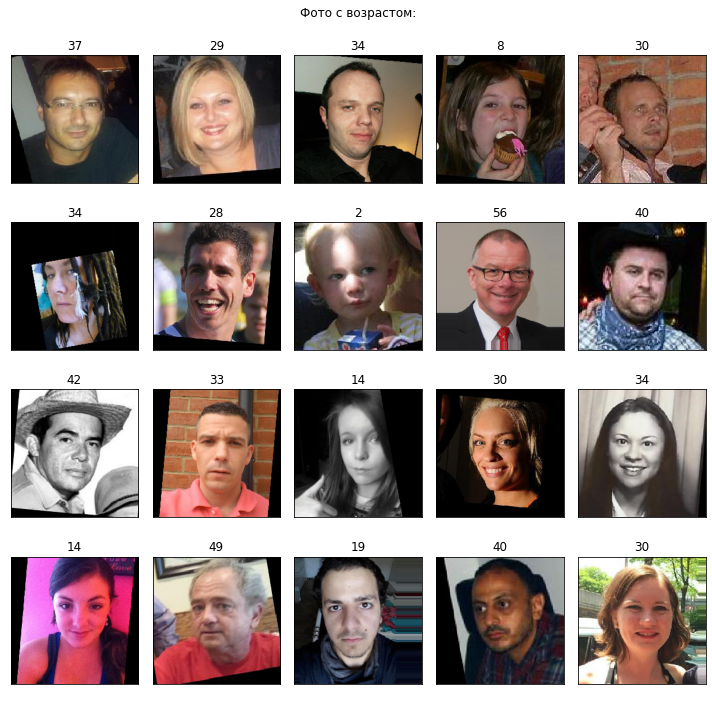

In [7]:
fig = plt.figure(figsize=(10,10))
plt.title('Фото с возрастом:')
plt.axis('off')
for i in range(20):
    fig.add_subplot(4, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i] )
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете приведены изображения с поворотом: часть фотографий повёрнута на некоторый угол, как будто старались на этих фото выровнять уровень глаз. Есть чёрно-белые фото, На некоторых фотографиях лицо закрыто очками или другими предметами. Часть фото меньше, чем 224х224 пикселя, у них чёрные рамки.
Посмотрела фото нескольких батчей, не встретила в них неправильной ориентации  лица, все фото повёрнуты верно.
Посмотрим на распределение возраста в выборке:

(array([149.,  88.,  25., 101.,  87.,  68.,  67.,  44.,  34.,  45.,  51.,
         56.,  79., 125., 128., 193., 163., 193., 180., 178., 143., 179.,
        213., 211., 315., 226., 229., 217., 164., 317., 129., 174., 144.,
        156., 147., 122., 144., 124., 107., 167.,  98.,  99.,  85.,  96.,
         88.,  74.,  93.,  66.,  74., 156.,  70.,  76.,  45.,  44.,  51.,
         41.,  37.,  54.,  41.,  75.,  28.,  28.,  20.,  23.,  36.,  18.,
         18.,  15.,  18.,  50.,  10.,  13.,  10.,   6.,  17.,   7.,   8.,
          3.,   6.,  31.,   3.,   5.,   3.,   8.,  12.,   3.,   6.,   3.,
          4.,  21.,   1.,   0.,   1.,   5.,   2.,   2.,   1.,   0.,   0.,
          1.]),
 array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
          8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
         16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  22.78,  23.77,
         24.76,  25.75,  26.74,  27.73,  28.72,  29.71,  30.7 ,  31.69,
         32.68,  33.67,  34.66

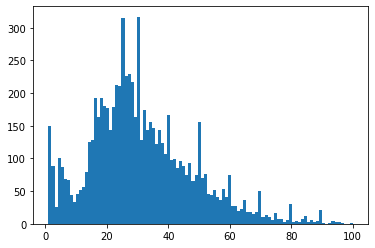

In [8]:
plt.hist(labels['real_age'], bins=100)

В выборке представлены фотографии людей разного возраста. Данные даны корректно: нет выбросов за сто лет, нет людей с отрицательным возрастом. Основная часть фотографий принадлежит людям возраста от 18ти до 50ти лет. Очень мало данных на людей старше 80ти лет. Возможно нейросеть будет плохо определять количество лет людей старшего возраста.

Также на гистограмме есть выбросы на юбилейных датах: 40, 50, 60 лет... Вероятно это связано с тем, что при разметке данных возраста округляли для удобства.

## Обучение модели

Код обучения модели и её результат вывода:

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def load_train(path):

    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1./255, 
                                       horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=pd.read_csv(path + 'labels.csv'),
                                                           directory=path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=42)
    return train_datagen_flow


def load_test(path):

    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=pd.read_csv(path + 'labels.csv'),
                                                         directory=path + 'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=42)
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, epochs=10, steps_per_epoch=None, batch_size=32, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

```

```


Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
178/178 - 44s - loss: 239.1205 - mae: 11.0493 - val_loss: 579.2143 - val_mae: 19.0375
Epoch 2/10
178/178 - 37s - loss: 74.8781 - mae: 6.5483 - val_loss: 517.0401 - val_mae: 17.5925
Epoch 3/10
178/178 - 37s - loss: 49.1432 - mae: 5.2977 - val_loss: 262.6857 - val_mae: 11.9448
Epoch 4/10
178/178 - 37s - loss: 33.7607 - mae: 4.4153 - val_loss: 115.0499 - val_mae: 8.0969
Epoch 5/10
178/178 - 37s - loss: 26.0739 - mae: 3.8884 - val_loss: 90.3922 - val_mae: 7.2061
Epoch 6/10
178/178 - 37s - loss: 21.0955 - mae: 3.5016 - val_loss: 74.5122 - val_mae: 6.6643
Epoch 7/10
178/178 - 37s - loss: 17.5363 - mae: 3.2415 - val_loss: 75.9349 - val_mae: 6.7297
Epoch 8/10
178/178 - 37s - loss: 14.7491 - mae: 2.9403 - val_loss: 102.3941 - val_mae: 7.6979
Epoch 9/10
178/178 - 37s - loss: 11.2872 - mae: 2.5747 - val_loss: 61.8528 - val_mae: 5.8483
Epoch 10/10
178/178 - 37s - loss: 10.2076 - mae: 2.4334 - val_loss: 62.8351 - val_mae: 6.0076
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 73.1190 - mae: 6.4138
Test MAE: 6.4138

Train for 178 steps, validate for 60 steps

Epoch 1/10

2022-06-13 16:27:30.858391: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-06-13 16:27:31.148779: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


```

## Анализ обученной модели

Средняя абсолютная ошибка на валидационной выборке составляет 6 лет, что меньше требуемой ошибки MAE=7.
Данная нейросеть с высокой точностью предсказывает возраст людей по фотографии. 

В нейросети 52 слоя. Первые 50 принадлежат архитектуре ResNet, которая хорошо справляется с обучением на изображениях.Последние два слоя это:
- GlobalAveragePooling2D — возвращает среднее значение из группы пикселей внутри канала.
- Dense — полносвязный слой для классификации. Он равен единице, поскольку на выходе нам нужно одно число. 

Из-за большого количества слоёв видно, что сеть переобучилась. на тренировочной выборке МАЕ всего 2.5, когда на валидационной 6.

Думаю, что если долго подбирать параметры, то можно добиться и лучших результатов, но и данная модель удовлетворяет всем условиям.

Эта модель не до конца справится с поставленной перед ней задачами:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы - с этим нейросеть справится, определять примерный возраст покупателя для классификации его в возрастную группу с ошибкой в шесть лет приемлемо;
- Контролировать добросовестность кассиров при продаже алкоголя - здесть сложно полностью довериться нейросети, если есть четкий возраст в 18 лет, то ошибка в шесть лет может быть существенной. Необходимо придумать грамотное применение данной модели в области контроля кассиров.